# TASK 3 : Customer Segmentation / Clustering

## Data Preprocessing

### import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import KElbowVisualizer

### Load datasets

In [ ]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

In [ ]:
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

### Merge dataset

In [ ]:
transactions = transactions.merge(products, on="ProductID", how="left")

customer_spending = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "TransactionID": "count",
    "Category": lambda x: x.mode()[0]
}).reset_index()

customer_spending.columns = ["CustomerID", "TotalSpend", "TransactionCount", "TopCategory"]

customer_profiles = customers.merge(customer_spending, on="CustomerID", how="left").fillna(0)

In [ ]:
customer_profiles.head()

,CustomerID,CustomerName,Region,SignupDate,TotalSpend,TransactionCount,TopCategory
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,Electronics
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,Clothing
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,Home Decor
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,Books
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,Electronics


### Feature Engineering

### Encode TopCategory and Region

In [ ]:
customer_profiles["Region"] = customer_profiles["Region"].astype(str)
customer_profiles["TopCategory"] = customer_profiles["TopCategory"].astype(str)

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(customer_profiles[["Region", "TopCategory"]])

In [ ]:
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["Region", "TopCategory"]))
customer_profiles = pd.concat([customer_profiles, encoded_df], axis=1).drop(["Region", "TopCategory", "CustomerName"], axis=1)

In [ ]:
customer_profiles.drop(["TopCategory_0"], axis=1, inplace=True)

### Scale the features

In [ ]:
scaled_features = customer_profiles.drop(columns=["CustomerID", "SignupDate"], errors="ignore")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(scaled_features)

In [ ]:
customer_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CustomerID               200 non-null    object        
 1   SignupDate               200 non-null    datetime64[ns]
 2   TotalSpend               200 non-null    float64       
 3   TransactionCount         200 non-null    float64       
 4   Region_Asia              200 non-null    float64       
 5   Region_Europe            200 non-null    float64       
 6   Region_North America     200 non-null    float64       
 7   Region_South America     200 non-null    float64       
 8   TopCategory_Books        200 non-null    float64       
 9   TopCategory_Clothing     200 non-null    float64       
 10  TopCategory_Electronics  200 non-null    float64       
 11  TopCategory_Home Decor   200 non-null    float64       
dtypes: datetime64[ns](1), float64(10), o

In [ ]:
customer_profiles.head()

,CustomerID,SignupDate,TotalSpend,TransactionCount,Region_Asia,Region_Europe,Region_North America,Region_South America,TopCategory_Books,TopCategory_Clothing,TopCategory_Electronics,TopCategory_Home Decor
0,C0001,2022-07-10,3354.52,5.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,C0002,2022-02-13,1862.74,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,C0003,2024-03-07,2725.38,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,C0004,2022-10-09,5354.88,8.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,C0005,2022-08-15,2034.24,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Choose a Clustering Algorithm

### Find Optimal K using Elbow Method

In [ ]:
wcss = []
K_range = range(2, 11)  # Try K values from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

### visualize elbow method

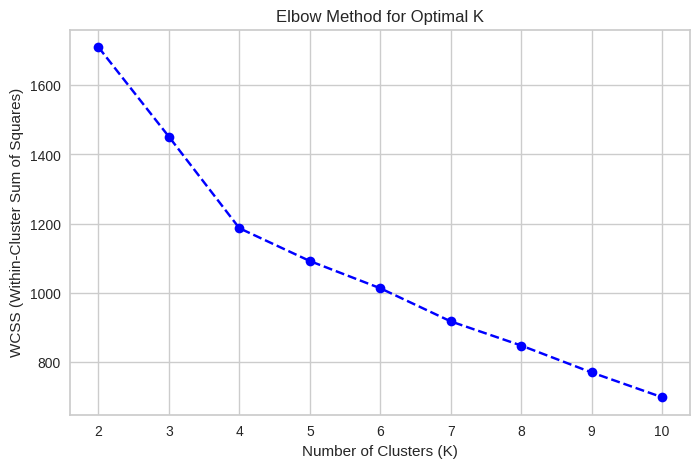

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker="o", linestyle="--", color="blue")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

## K-Means Clustering

In [ ]:
optimal_k = 4
print(f"Number of clusters formed: {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_profiles["Cluster"] = kmeans.fit_predict(scaled_features)

Number of clusters formed: 4


In [ ]:
db_index = davies_bouldin_score(scaled_features, customer_profiles["Cluster"])
silhouette = silhouette_score(scaled_features, customer_profiles["Cluster"])

In [ ]:
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

Davies-Bouldin Index: 1.4647205357825546
Silhouette Score: 0.294915107960944


## Visualize the Clusters

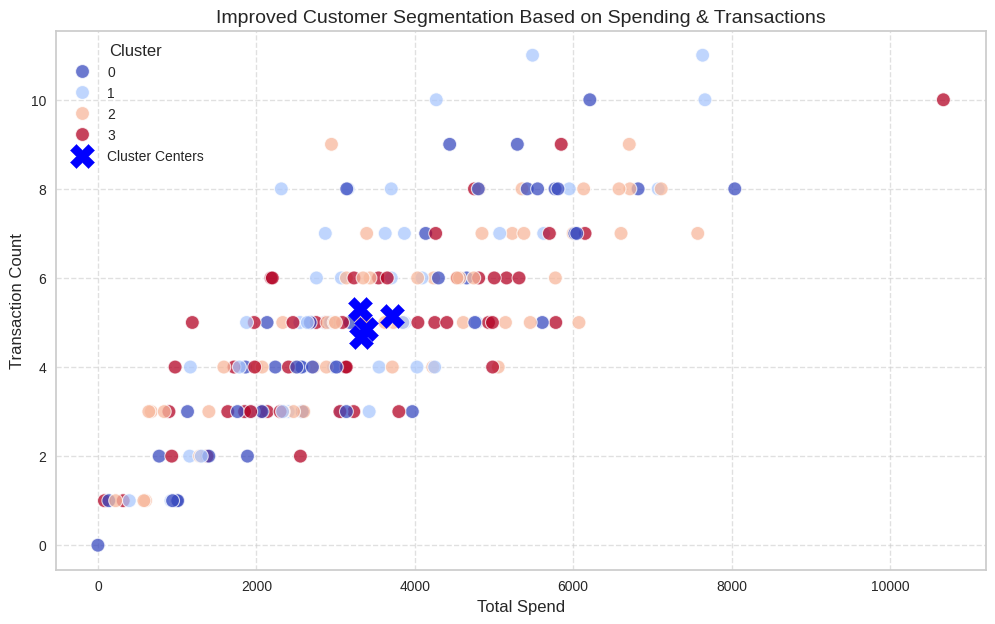

In [ ]:
plt.figure(figsize=(12, 7))

sns.scatterplot(x=customer_profiles["TotalSpend"],
                y=customer_profiles["TransactionCount"],
                hue=customer_profiles["Cluster"],
                palette="coolwarm",
                s=100,
                alpha=0.75)

kmeans_centers = customer_profiles.groupby("Cluster")[["TotalSpend", "TransactionCount"]].mean()
plt.scatter(kmeans_centers["TotalSpend"], kmeans_centers["TransactionCount"],
            s=300, c="blue", marker="X", label="Cluster Centers")

plt.title("Improved Customer Segmentation Based on Spending & Transactions", fontsize=14)
plt.xlabel("Total Spend", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


### save the clustered data

In [ ]:
customer_profiles.to_csv("Customer_Segments.csv", index=False)
print("Customer segmentation completed. Results saved to Customer_Segments.csv.")

Customer segmentation completed. Results saved to Customer_Segments.csv.
